In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
start = '2015-01-01'
end = '2017-01-01'

united = pd.read_csv(os.path.join(os.curdir, 'data', 'UAL_history.csv'), index_col='Date', parse_dates=True)
american = pd.read_csv(os.path.join(os.curdir, 'data', 'AAL_history.csv'), index_col='Date', parse_dates=True)

In [3]:
american.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2016-12-30,46.69,47.42,47.66,46.47,4.50M,-1.19%
2016-12-29,47.25,47.80,48.00,46.96,3.71M,-0.88%
2016-12-28,47.67,48.73,48.83,47.61,4.15M,-1.93%
2016-12-27,48.61,48.29,48.92,48.14,2.80M,0.27%
2016-12-23,48.48,48.61,48.84,48.28,2.92M,-0.43%


Text(0, -60, 'Correlation of 0.91261514')

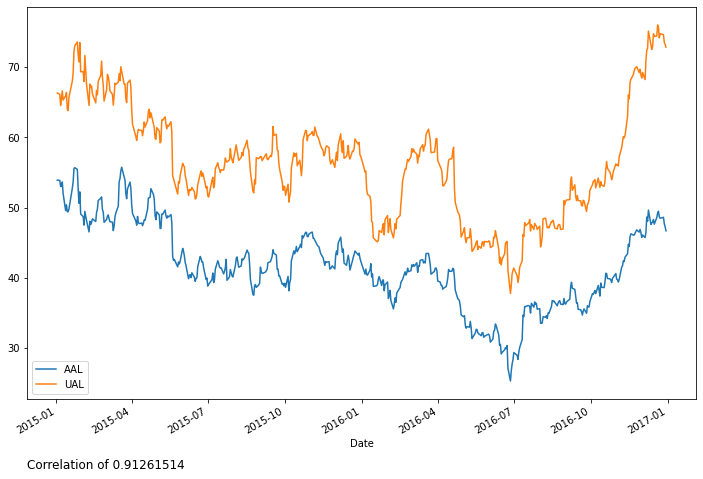

In [4]:
american['Price'].plot(label='AAL', figsize=(12,8))
united['Price'].plot(label='UAL', figsize=(12,8))
plt.legend()
plt.annotate('Correlation of 0.91261514', (0,0), (0,-60), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=12)

In [5]:
american.drop(american.tail(1).index, inplace=True, axis=0)
american.describe()

,Price,Open,High,Low
count,504.000000,504.000000,504.000000,504.000000
mean,41.626905,41.642738,42.251647,41.003214
std,5.872982,5.908126,5.939441,5.819533
min,25.270000,26.120000,26.850000,24.850000
25%,38.192500,38.127500,38.777500,37.347500
50%,41.355000,41.355000,41.865000,40.705000
75%,46.012500,46.142500,46.542500,45.460000
max,55.760000,55.890000,56.200000,54.860000


In [6]:
np.corrcoef(american['High'], united['High'])

array([[1.        , 0.91261514],
       [0.91261514, 1.        ]])

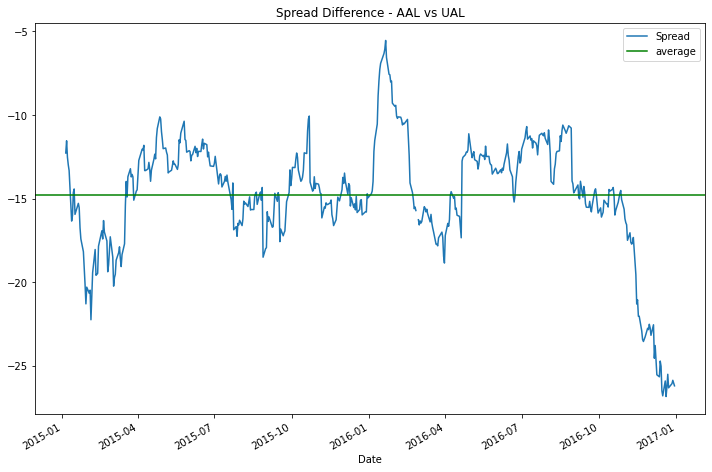

In [7]:
spread = american['Price'] - united['Price']
spread.plot(label='Spread', figsize=(12,8), title='Spread Difference - AAL vs UAL')
plt.axhline(spread.mean(), c='g', label='average')
plt.legend()

In [8]:
def zscore(stocks):
    return (stocks-stocks.mean()) / np.std(stocks)


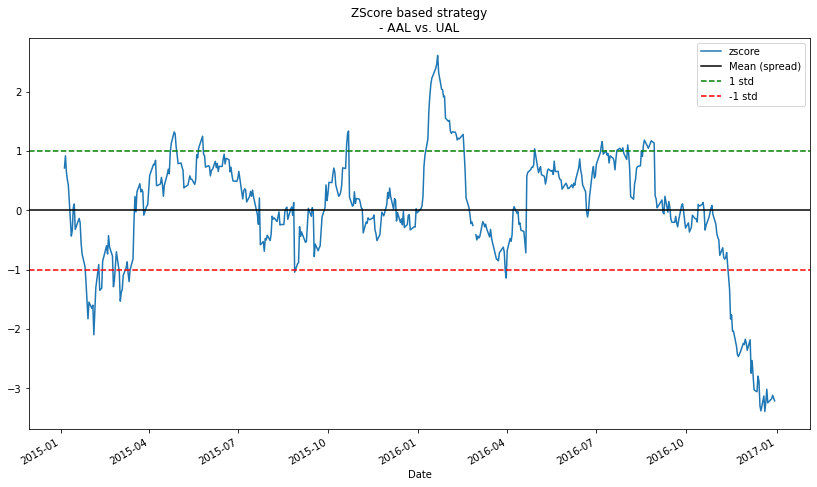

In [9]:
zscore(spread).plot(figsize=(14,8), label='zscore', title='ZScore based strategy\n- AAL vs. UAL')
plt.axhline(zscore(spread).mean(), color='black', label='Mean (spread)')
plt.axhline(1.0, c='g', ls='--', label='1 std')
plt.axhline(-1.0, c='r', ls='--', label='-1 std')
plt.legend()

# This strategy wont work with our platform since it relies entirely on known data.  Will need to calc a rolling zscore to handle future data.

In [10]:
# Calculating a rolling zscore

spread_ma1 = spread.rolling(1).mean()
spread_ma30 = spread.rolling(30).mean()
std_30 = spread.rolling(30).std()

zscore_30_1 = (spread_ma1 - spread_ma30) / std_30

In [12]:
zscore_30_1

Date
2015-01-02         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
                ...   
2016-12-23   -1.176253
2016-12-27   -1.086287
2016-12-28   -0.954296
2016-12-29   -0.994798
2016-12-30   -1.043309
Name: Price, Length: 505, dtype: float64

Text(0, -50, 'Hypothesis: \n    UAL and AAL prices are highly correlated (based on np.corrcoef). \n    When the zscore > 1 std difference of mean, sell AAL and buy UAL. Same for opposite.')

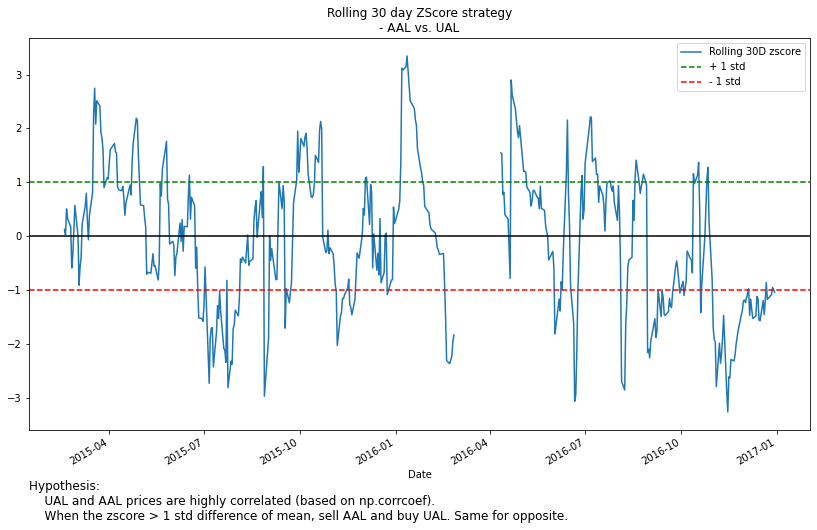

In [13]:
zscore_30_1.plot(figsize=(14,8), label='Rolling 30D zscore', title='Rolling 30 day ZScore strategy\n- AAL vs. UAL')
plt.axhline(0, color='black')
plt.axhline(1.0, c='g', ls='--', label='+ 1 std')
plt.axhline(-1.0, c='r', ls='--', label='- 1 std')
plt.legend()

plt.annotate('Hypothesis: \n    UAL and AAL prices are highly correlated (based on np.corrcoef). \n    When the zscore > 1 std difference of mean, sell AAL and buy UAL. Same for opposite.', (0,0), (0,-50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=12)

## Script for Backtesting

In [ ]:
"""
Strategy based on the 30D rolling ZScore
"""

# Zipline
from zipline.api import(    symbol,
                            order_target_percent,
                            schedule_function,
                            date_rules,
                            time_rules,
                       )
import numpy as np
import pandas as pd


# Initialize - Schedule funciton 
def initialize(context):
    schedule_function(check_pairs, date_rules.every_day(), time_rules.market_close(minutes=60))

    context.aal = symbol('AAL')
    context.ual = symbol('UAL')

    context.long_on_spread = False
    context.shorting_spread = False

# Check pairs
def check_pairs(context, data):

    aal = context.aal
    ual = context.ual

    prices = data.history([aal, ual], 'price', 30, '1d')
    short_prices = prices.iloc[-1:]

    # Spread
    ma_30 = np.mean(prices[aal] - prices[ual])
    std_30 = np.std(prices[aal] - prices[ual])

    ma_1 = np.mean(short_prices[aal] - short_prices[ual])

    if std_30 > 0:
        zscore = (ma_1 - ma_30)/std_30

        if zscore < 1.0 and not context.shorting_spread:
            # Short UAL - Long AAL
            try:
                order_target_percent(aal, -0.5)
                order_target_percent(ual, 0.5)
                context.shorting_spread = True
                context.long_on_spread = False
            except:
                pass
        elif zscore > 1.0 and not context.long_on_spread:
            # Short AAL - Long UAL
            try:
                order_target_percent(aal, 0.5)
                order_target_percent(ual, -0.5)
                context.shorting_spread = False
                context.long_on_spread = True
            except:
                pass
        elif abs(zscore) < 0.1:
            # Exit positions
            order_target_percent(aal, 0)
            order_target_percent(ual, 0)
            context.shorting_spread = False
            context.long_on_spread = False




















